In [39]:
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install librosa scikit-learn torch torchvision matplotlib

# **Loading the dataset**

In [2]:
baby_dataset = '/kaggle/input/infant-cry-audio-corpus/donateacry_corpus'

In [3]:
classes = os.listdir(baby_dataset)
classes

['hungry', 'burping', 'discomfort', 'belly_pain', 'tired']

In [4]:
audio_path = [] 
audio_class = []
for label in classes:
    label_dir = os.path.join(baby_dataset, label)
    for file in os.listdir(label_dir):
        if file.endswith(".wav"):
            file_path = os.path.join(label_dir,file)
            audio_path.append(file_path)
            audio_class.append(label)

In [5]:
len(audio_class)

457

# *Data Visualization*

In [6]:
class_df = pd.DataFrame(audio_class, columns = ['Classes'])
path_df = pd.DataFrame(audio_path, columns = ['Path'])
dataset = pd.concat([class_df, path_df], axis=1)
dataset.head()

,Classes,Path
0,hungry,/kaggle/input/infant-cry-audio-corpus/donateac...
1,hungry,/kaggle/input/infant-cry-audio-corpus/donateac...
2,hungry,/kaggle/input/infant-cry-audio-corpus/donateac...
3,hungry,/kaggle/input/infant-cry-audio-corpus/donateac...
4,hungry,/kaggle/input/infant-cry-audio-corpus/donateac...


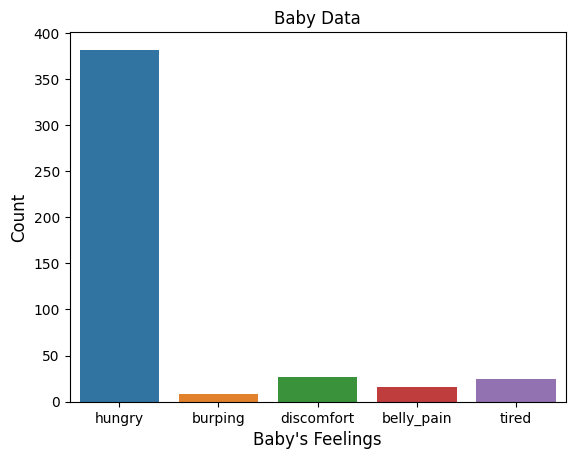

In [7]:
plt.title('Baby Data')
sns.countplot(data=dataset,x= 'Classes')
plt.ylabel("Count", size=12)
plt.xlabel("Baby's Feelings", size=12)
plt.show()

# *Augument Data to get more audio files for undermined classes*

In [8]:
def augment_audio(audio, sr):
    audio_shifted = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=2)
    audio_stretched = librosa.effects.time_stretch(y=audio, rate=0.9)

    
    noise = np.random.normal(0, 0.005, audio.shape)
    audio_noisy = audio + noise

    return [audio, audio_shifted, audio_stretched, audio_noisy]

# *Converting Audio to Spectogram*

*Creating a spectrogram for a single audio file*

In [9]:
path = audio_path[383]
path

'/kaggle/input/infant-cry-audio-corpus/donateacry_corpus/burping/AEA8AE04-D00E-48A7-8A0B-6D87E2175121-1430563241-1.0-f-72-bu.wav'

In [10]:
waveform, sampling_rate = librosa.load(path)

In [11]:
sampling_rate

22050

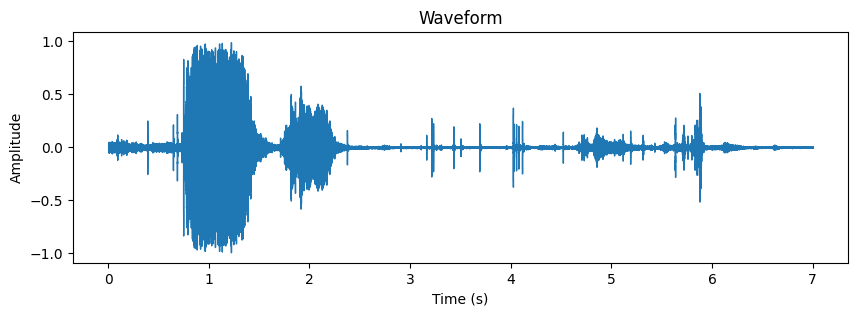

In [12]:
plt.figure(figsize=(10, 3))
librosa.display.waveshow(waveform, sr=sampling_rate)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

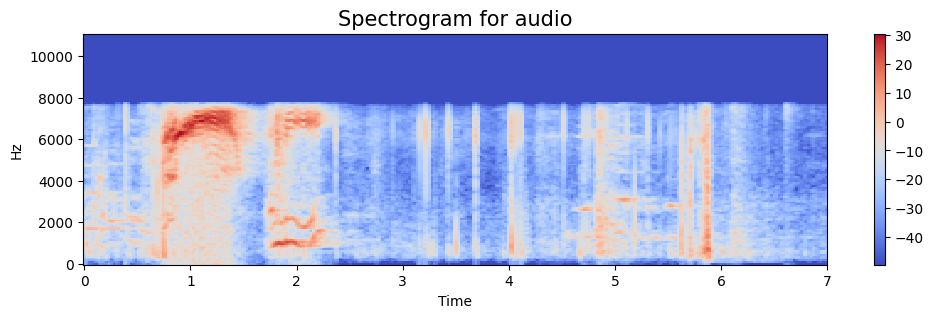

In [16]:
mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sampling_rate, n_mels=128)
spectro_db = librosa.power_to_db(mel_spectrogram)

plt.figure(figsize=(12, 3))
plt.title('Spectrogram for audio', size=15)
librosa.display.specshow(spectro_db, sr=sampling_rate, x_axis='time', y_axis='hz')   
plt.colorbar()

**Creating a function to create spectogram for the entire dataset**

In [17]:
def audio_to_spectrogram(waveform, sr, max_len=128):
    spectro = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels = 128)
    spectro_db = librosa.power_to_db(spectro)

    #Ensures each spectrogram is the same shape (128,128)
    if spectro_db.shape[1] < max_len:
        pad_width = max_len - spectro_db.shape[1]
        spectro_db = np.pad(spectro_db, pad_width=((0, 0), (0, pad_width)))
    else:
        spectro_db = spectro_db[:, :max_len]

    
    # plt.figure(figsize=(12, 3))
    # plt.title('Spectrogram for audio', size=15)
    # librosa.display.specshow(spectro_db, sr=sr, x_axis='time', y_axis='hz')   
    # plt.colorbar()

    return spectro_db

In [18]:
a_path = audio_path[380]
a_path

'/kaggle/input/infant-cry-audio-corpus/donateacry_corpus/hungry/b5044f9a-6f2e-44fc-8e04-9076a988acf2-1435544527174-1.7-m-04-hu.wav'

In [19]:
waveform, sampling_rate = librosa.load(a_path)
audio_to_spectrogram(waveform, sampling_rate)

array([[-58.084858 , -58.084858 , -58.084858 , ..., -36.89434  ,
        -34.824757 , -31.277874 ],
       [-58.084858 , -58.084858 , -58.084858 , ..., -12.265442 ,
         -9.816913 , -11.908962 ],
       [-58.084858 , -58.084858 , -58.084858 , ...,  -6.2117558,
         -4.8617716,  -9.475852 ],
       ...,
       [-58.084858 , -58.084858 , -58.084858 , ..., -58.084858 ,
        -58.084858 , -58.084858 ],
       [-58.084858 , -58.084858 , -58.084858 , ..., -58.084858 ,
        -58.084858 , -58.084858 ],
       [-58.084858 , -58.084858 , -58.084858 , ..., -58.084858 ,
        -58.084858 , -58.084858 ]], dtype=float32)

# Loading main data and creating a spectrogram for each audio file

In [20]:
from tqdm import tqdm

In [24]:
def balance_dataset(baby_dataset, target_size=100):
    audio_paths = defaultdict(list)

    # Step 1: Collect all audio files by class
    for label in os.listdir(baby_dataset):
        label_dir = os.path.join(baby_dataset, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    file_path = os.path.join(label_dir, file)
                    audio_paths[label].append(file_path)

    spec_images = []
    labels = []

    for label, files in tqdm(audio_paths.items()):
        count = len(files)
        needed = max(0, target_size - count)
        print(f"{label}: {count} samples, augmenting {needed} more")

        for file_path in files:
            waveform, sr = librosa.load(file_path)
            
            # Always include original
            spectro = audio_to_spectrogram(waveform, sr)
            spec_images.append(spectro)
            labels.append(label)

            # Augment only if needed
            if needed > 0:
                augmented = augment_audio(waveform, sr)
                for a in augmented:
                    if needed <= 0:
                        break
                    spectro_aug = audio_to_spectrogram(a, sr)
                    spec_images.append(spectro_aug)
                    labels.append(label)
                    needed -= 1

    return np.array(spec_images), np.array(labels)

In [25]:
X, y = balance_dataset(baby_dataset, target_size=100)

  0%|          | 0/5 [00:00<?, ?it/s]

hungry: 382 samples, augmenting 0 more


 20%|██        | 1/5 [00:06<00:25,  6.39s/it]

burping: 8 samples, augmenting 92 more


 40%|████      | 2/5 [00:07<00:10,  3.46s/it]

discomfort: 27 samples, augmenting 73 more


 60%|██████    | 3/5 [00:11<00:06,  3.49s/it]

belly_pain: 16 samples, augmenting 84 more


 80%|████████  | 4/5 [00:14<00:03,  3.23s/it]

tired: 24 samples, augmenting 76 more


100%|██████████| 5/5 [00:17<00:00,  3.53s/it]


# *Convert the spectrogram output into a numpy array then to a tensor to be used by CNN*

In [26]:
X = X[:, np.newaxis, :, :]  # Add channel dimension: (N, 1, 128, 128)

*Converting the classes "hungry", "tired", ... into numbers for the CNN to understand*

In [27]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = np.array(y)

In [28]:
y

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [29]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# Then split what's left into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15 / 0.85, stratify=y_temp, random_state=42)

#so I now have test, train, val

In [30]:
len(X_val)

106

In [31]:
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).long()
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).long()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).long()

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# *Build the CNN MODEL!*

In [32]:
class BabyCry(nn.Module):
    def __init__(self, num_classes):
        super(BabyCry, self).__init__()
        self.conv1 = nn.Conv2d(1,16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32*32*32, 128)
        self.fc2 = nn.Linear(128, num_classes)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # (N, 16, 64, 64) - Outputs = N batch size, 16 out channels/filters, 64 height of output image, 64 width of output image
        x = self.pool(F.relu(self.conv2(x))) #(N,32,32,32)
        x = x.view(-1, 32 * 32 * 32) #flatten output image
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [33]:
model = BabyCry(num_classes=len(classes))

# *Train the MODEL!*

*You see, some of the classes are underrepresented, so I'm trying to force the model to pay more attention to them by watching the class weights*

In [34]:
class_names = sorted(set(classes))  # ['belly_pain', 'burping', ...]
label_to_index = {label: idx for idx, label in enumerate(class_names)}
indexed_labels = [label_to_index[label] for label in classes]

# Compute weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(indexed_labels),
    y=indexed_labels
)

# Convert to tensor
weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [35]:
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
for epoch in range(15):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

Epoch 1, Loss: 215.6449
Epoch 2, Loss: 31.5312
Epoch 3, Loss: 18.4285
Epoch 4, Loss: 9.5005
Epoch 5, Loss: 4.7358
Epoch 6, Loss: 2.0583
Epoch 7, Loss: 1.3831
Epoch 8, Loss: 0.7791
Epoch 9, Loss: 0.6842
Epoch 10, Loss: 0.2887
Epoch 11, Loss: 0.0870
Epoch 12, Loss: 0.0362
Epoch 13, Loss: 0.0241
Epoch 14, Loss: 0.0154
Epoch 15, Loss: 0.0108


# *Evaluate the MODEL!*

In [40]:
def evaluate_model(model, data_loader, class_names=None, label="Validation"):
    model.eval()
    y_true = []
    y_pred = []
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.append(y_batch)
            y_pred.append(predicted)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    print(f"{label} Accuracy: {accuracy:.2f}")

    y_true_flat = torch.cat(y_true).cpu().numpy()
    y_pred_flat = torch.cat(y_pred).cpu().numpy()

    print(f"\n{label} Classification Report:")
    print(classification_report(y_true_flat, y_pred_flat, target_names=class_names))
    

    print(f"\n{label} Confusion Matrix:")
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Validation Accuracy: 0.77

Validation Classification Report:
              precision    recall  f1-score   support

      hungry       0.92      0.92      0.92        12
     burping       1.00      0.50      0.67         6
  discomfort       0.64      0.60      0.62        15
  belly_pain       0.79      0.90      0.84        58
       tired       0.64      0.47      0.54        15

    accuracy                           0.77       106
   macro avg       0.80      0.68      0.72       106
weighted avg       0.77      0.77      0.76       106


Validation Confusion Matrix:


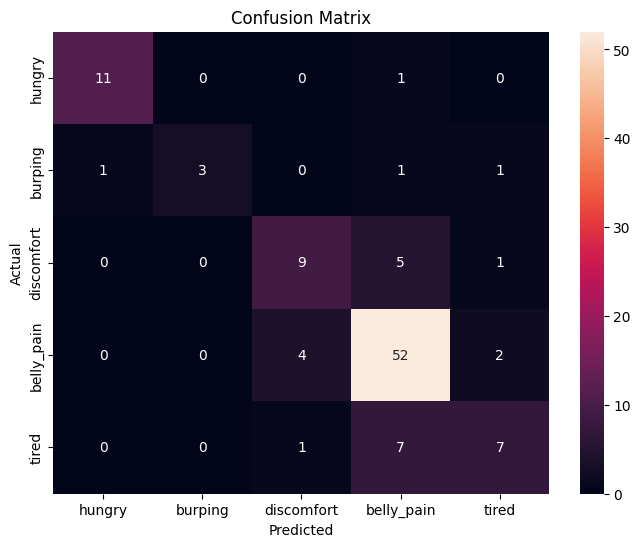

Test Accuracy: 0.86

Test Classification Report:
              precision    recall  f1-score   support

      hungry       0.79      0.92      0.85        12
     burping       1.00      0.83      0.91         6
  discomfort       0.92      0.80      0.86        15
  belly_pain       0.91      0.90      0.90        58
       tired       0.65      0.73      0.69        15

    accuracy                           0.86       106
   macro avg       0.85      0.84      0.84       106
weighted avg       0.87      0.86      0.86       106


Test Confusion Matrix:


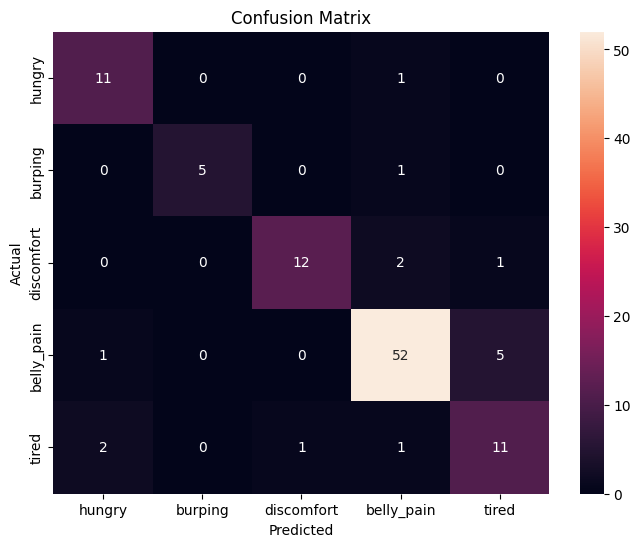

In [41]:
#for validation data
evaluate_model(model,val_loader, classes, label='Validation')
#for testing data
evaluate_model(model, test_loader, classes, label='Test')

In [ ]:
y_values, p_values

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten your list of tensors
y_true = torch.cat(y_values).numpy()
y_pred = torch.cat(p_values).numpy()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=classes))

# Saving the MODEL!

In [42]:
torch.save(model.state_dict(), 'infant_cry_model_state.pt')